# Importing Data from Kaggle

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hotsonhonet","key":"e6cb444362df8bdc68a95a96af34b13c"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d rakshana0802/face-mask-detection-data

 99% 126M/127M [00:00<00:00, 141MB/s]
100% 127M/127M [00:00<00:00, 163MB/s]


In [7]:
!ls

face-mask-detection-data.zip  kaggle.json  sample_data


In [8]:
from zipfile import ZipFile

with ZipFile("face-mask-detection-data.zip", 'r') as file:
    file.extractall()

# Downloading livelossplot

In [9]:
!pip install livelossplot

# Importing Modules

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

from livelossplot import PlotLossesKeras
from keras.utils.vis_utils import plot_model

import cv2
import os
import shutil
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading Data

In [11]:
masked_images_loc = "/content/with_mask"
unmasked_images_loc = "/content/without_mask"

In [12]:
data = {"path":[], "label":[]}

for img in os.listdir(masked_images_loc):
    data['path'].append(masked_images_loc + "/" + img)
    data['label'].append("Masked")

for img in os.listdir(unmasked_images_loc):
    data['path'].append(unmasked_images_loc + "/" + img)
    data['label'].append("Unmasked")

data = pd.DataFrame(data)
data = data.sample(data.shape[0]).reset_index(drop = True)
data

,path,label
0,"/content/without_mask/Faceimg1,854.jpg",Unmasked
1,/content/without_mask/Faceimg977.jpg,Unmasked
2,"/content/without_mask/Faceimg1,361.jpg",Unmasked
3,"/content/with_mask/image1,180.jpg",Masked
4,/content/without_mask/Faceimg11.jpg,Unmasked
...,...,...
3828,"/content/without_mask/Faceimg1,700.jpg",Unmasked
3829,"/content/without_mask/Faceimg1,481.jpg",Unmasked
3830,/content/with_mask/image683.jpeg,Masked
3831,/content/with_mask/image271.jpg,Masked


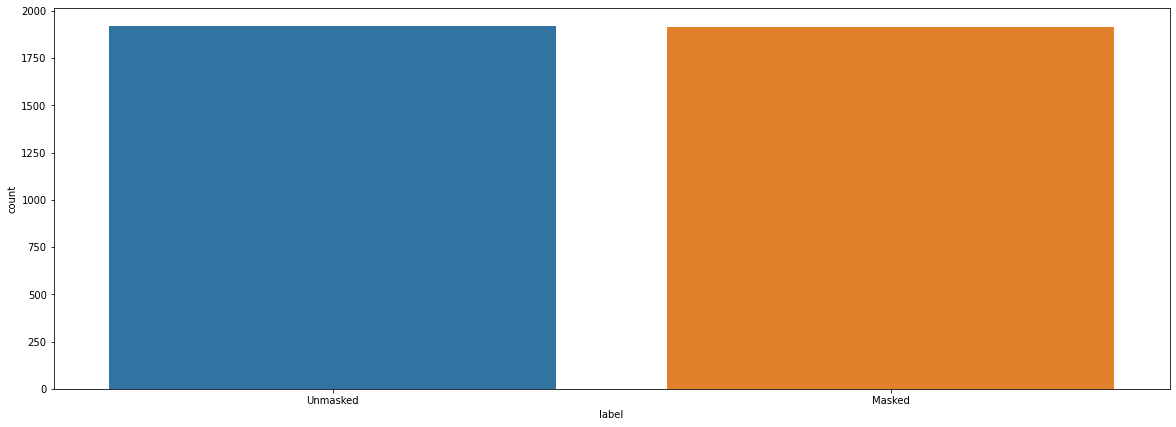

In [13]:
plt.figure(figsize = (20, 7))
sns.countplot(data['label'])
plt.show();

# Preparing our training and validation data

In [14]:
features = []; labels = []

In [15]:
map_label = {"Masked" : 1, "Unmasked": 0}
data["num_label"] = data.label.apply(lambda x: map_label[x])
data

,path,label,num_label
0,"/content/without_mask/Faceimg1,854.jpg",Unmasked,0
1,/content/without_mask/Faceimg977.jpg,Unmasked,0
2,"/content/without_mask/Faceimg1,361.jpg",Unmasked,0
3,"/content/with_mask/image1,180.jpg",Masked,1
4,/content/without_mask/Faceimg11.jpg,Unmasked,0
...,...,...,...
3828,"/content/without_mask/Faceimg1,700.jpg",Unmasked,0
3829,"/content/without_mask/Faceimg1,481.jpg",Unmasked,0
3830,/content/with_mask/image683.jpeg,Masked,1
3831,/content/with_mask/image271.jpg,Masked,1


In [16]:
for img_path, label in zip(list(data.path.values), list(data.num_label.values)):
    img = load_img(img_path, target_size = (224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)

    features.append(img)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

print(f"Features shape : {features.shape}")
print(f"Labels shape : {labels.shape}")

Features shape : (3833, 224, 224, 3)
Labels shape : (3833,)


In [17]:
labels = to_categorical(labels)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Training Process

In [18]:
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size = 0.3, random_state = 30)

print(f"Shape of x_train is : {x_train.shape}")
print(f"Shape of y_train is : {y_train.shape}")
print(f"Shape of x_val is : {x_val.shape}")
print(f"Shape of y_val is : {y_val.shape}")

Shape of x_train is : (2683, 224, 224, 3)
Shape of y_train is : (2683, 2)
Shape of x_val is : (1150, 224, 224, 3)
Shape of y_val is : (1150, 2)


# Creating our data augmenter

In [19]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Creating Our Model

In [26]:
class VGG_16:
    def __init__(self, trainable, loss, metrics, optimizer, num_classes):
        self.vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        for layer in self.vgg.layers:
            layer.trainiable = trainable
        # self.vgg.trainable = trainable
        self.loss = loss
        self.metrics = metrics
        self.optimizer = optimizer
        self.num_classes = num_classes

    def vgg_model(self):
        self.model = Sequential()
        self.model.add(self.vgg)
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(self.num_classes, activation='softmax'))

        self.model.compile(loss=self.loss, metrics=self.metrics, optimizer=self.optimizer)

        return self.model


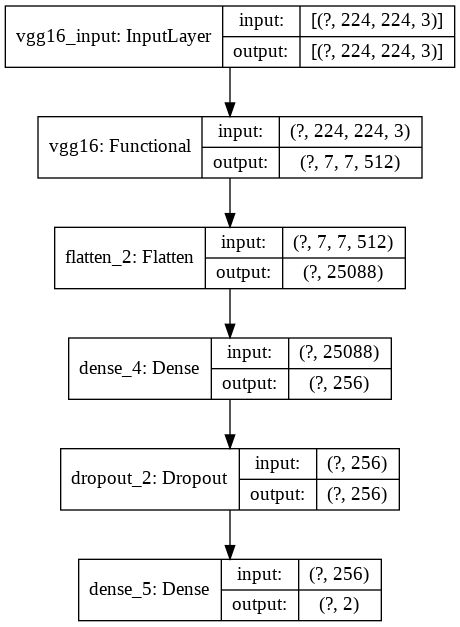

In [27]:
model = VGG_16(False, 'categorical_crossentropy', ['accuracy'], 'adam', 2)
model = model.vgg_model()

plot_model(model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)

## Setting callbacks

In [28]:
liveplot = PlotLossesKeras()
batch_size = 32
train_size = len(x_train)
val_size = len(x_val)
EPOCHS = 20

# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2, patience = 5, min_lr = 2e-5, mode = 'min')

callbacks = [liveplot]

## Training our model

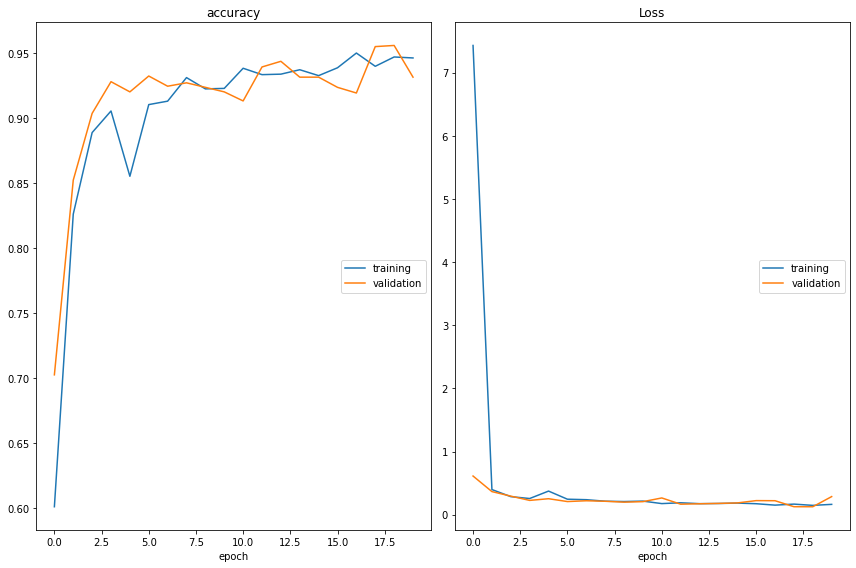

accuracy
	training         	 (min:    0.601, max:    0.950, cur:    0.946)
	validation       	 (min:    0.703, max:    0.956, cur:    0.931)
Loss
	training         	 (min:    0.147, max:    7.431, cur:    0.163)
	validation       	 (min:    0.125, max:    0.612, cur:    0.286)
83/83 [==============================] - 46s 556ms/step - loss: 0.1628 - accuracy: 0.9461 - val_loss: 0.2859 - val_accuracy: 0.9313


In [29]:
training_logs = model.fit(
    	aug.flow(x_train, y_train,batch_size=batch_size),
        	steps_per_epoch= train_size//batch_size,
            	validation_data=(x_val, y_val),
                	validation_steps= val_size//batch_size,
                    	epochs=EPOCHS,
                        callbacks = callbacks)

# Saving the model

In [30]:
model.save("/content/Saved_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/Saved_model/assets


INFO:tensorflow:Assets written to: /content/Saved_model/assets


In [33]:
!zip -r /content/MaskedVsUnMaskedClassifier_Model.zip /content/Saved_model

  adding: content/Saved_model/ (stored 0%)
  adding: content/Saved_model/variables/ (stored 0%)
  adding: content/Saved_model/variables/variables.index (deflated 74%)
  adding: content/Saved_model/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/Saved_model/assets/ (stored 0%)
  adding: content/Saved_model/saved_model.pb (deflated 92%)


In [32]:
!ls

face-mask-detection-data.zip  kaggle.json  Saved_model	  with_mask
GenderClassifier_Model.zip    sample_data  vgg_model.png  without_mask


In [34]:
from google.colab import files
files.download("MaskedVsUnMaskedClassifier_Model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>